In [1]:
import collections
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model, Sequential
from keras.layers import GRU, LSTM, Input, Dense, TimeDistributed, Embedding, Activation, RepeatVector, Bidirectional, Concatenate, Dot
from keras.layers.embeddings import Embedding
from keras.optimizers import Adam
from keras.losses import sparse_categorical_crossentropy
from keras.preprocessing.text import one_hot
from keras.utils import np_utils
from sklearn.preprocessing import label_binarize

Using TensorFlow backend.


In [0]:
train = pd.read_csv('/content/DataSet/train.csv')
test = pd.read_csv('/content/DataSet/test.csv')

In [4]:
x_train = train['sentence'].as_matrix()
y_train = train['relation'].as_matrix()

x_test = test['sentence'].as_matrix()
y_test = test['relation'].as_matrix()

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """


In [0]:
x_train2c=[]
x_train2t=[]
for i in range(13340):
  if y_train[i] == 'causes':
    x_train2c.append(x_train[i])
  elif y_train[i] == 'treats':
    x_train2t.append(x_train[i])    
x_test2c=[]
x_test2t=[]
for i in range(4566):
  if y_test[i] == 'causes':
    x_test2c.append(x_test[i])
  elif y_test[i] == 'treats':
    x_test2t.append(x_test[i])

In [0]:
causesTrain=pd.Series(x_train2c).unique()
treatsTrain=pd.Series(x_train2t).unique()
causesTest=pd.Series(x_test2c).unique()
treatsTest=pd.Series(x_test2t).unique()

In [0]:
X_train=[]
X_test=[]
y_train=[]
y_test=[]
for i in causesTrain:
  X_train.append(i)
  y_train.append(0)
for i in treatsTrain:
  X_train.append(i)
  y_train.append(1)
for i in causesTest:
  X_test.append(i)
  y_test.append(0)
for i in treatsTest:
  X_test.append(i)
  y_test.append(1)
  

In [0]:
df=pd.DataFrame()
df['Frase']=X_train
df['Label']=y_train

In [0]:
dftest=pd.DataFrame()
dftest['Frase']=X_test
dftest['Label']=y_test

* Observemos el desbalanceo de clases

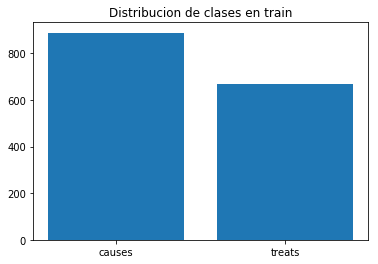

In [10]:
plt.bar(['causes','treats'],df['Label'].value_counts())
plt.title('Distribucion de clases en train');

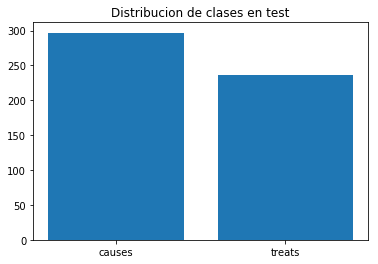

In [11]:
plt.bar(['causes','treats'],dftest['Label'].value_counts())
plt.title('Distribucion de clases en test');

* Existe desbalance de clase, lo tendremos en cuenta en los parametros del modelo.

* El set de datos estaba particionado completamente, aplicamos un muestreo para 'desordenar' el dataframe.

In [12]:
dftest=dftest.sample(frac=1).reset_index(drop=True)
df=df.sample(frac=1).reset_index(drop=True)
df.head(10)

,Frase,Label
0,Lacunes consist of small vascular lesions with...,0
1,"Of the 5,442 ticks collected, 90% (4,893) were...",0
2,DIABETIC NEUROPATHY is the most frequent compl...,0
3,"476 , 477 , 478 Latent Viral Infections ...",0
4,GRANULOMA INGUINALE (Donovanosis) GRANULOMA ...,0
5,For a critically ill patient thought to be at ...,1
6,The patients showed the characteristic facies ...,0
7,"Ferman TJ, Boeve BF, Smith GE, et alDEMENTIA W...",0
8,BC] Specific recommendation: • Consider under...,0
9,No major differences in the severity of HEROIN...,0


### Preprocesamiento de los datos

* Eliminacion de Stopwords y palabras no deseadas
* Tokenizacion
* Padding

In [13]:
import nltk
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [0]:
aW=[]
# Removing Stop Words
import re 
processed_article = df['Frase'].values

for j in range(df['Frase'].values.shape[0]):  
    processed_article[j] = re.sub("'S", ' ', processed_article[j])  
    processed_article[j] = re.sub('[^a-zA-Z]', ' ', processed_article[j])    
    processed_article[j] = re.sub(r'\s+', ' ', processed_article[j])
    # Preparing the dataset
    all_sentences = nltk.sent_tokenize(processed_article[j])
    all_words = [nltk.word_tokenize(sent) for sent in all_sentences]
    for i in range(len(all_words)):
      
        all_words[i] = [w.lower() for w in all_words[i] if w not in stopwords.words('english')]
        all_words[i] = [w for w in all_words[i] if w not in ['s','l','a','the','of','v','tu','t','b','c','g','e','p','m','d','j','i']]

    aW.append(all_words[0])

In [0]:
aWt=[]
# Removing Stop Words
import re 
processed_article = dftest['Frase'].values

for j in range(dftest['Frase'].values.shape[0]):  
    processed_article[j] = re.sub("'S", ' ', processed_article[j])  
    processed_article[j] = re.sub('[^a-zA-Z]', ' ', processed_article[j])    
    processed_article[j] = re.sub(r'\s+', ' ', processed_article[j])
    # Preparing the dataset
    all_sentences = nltk.sent_tokenize(processed_article[j])
    all_words = [nltk.word_tokenize(sent) for sent in all_sentences]
    for i in range(len(all_words)):
      
        all_words[i] = [w.lower() for w in all_words[i] if w not in stopwords.words('english')]
        all_words[i] = [w for w in all_words[i] if w not in ['s','l','a','the','of','v','tu','t','b','c','g','e','p','m','d','j','i']]

    aWt.append(all_words[0])

In [0]:
max_fatures = 2000
tokenizer = Tokenizer(num_words=max_fatures, split=' ')
tokenizer.fit_on_texts(aW)
X = tokenizer.texts_to_sequences(aW)
Xt = tokenizer.texts_to_sequences(aWt)

In [17]:
from keras.preprocessing.sequence import pad_sequences
Xpad=pad_sequences(X,padding='post',maxlen=25)
voc=Xpad[0].size
print('El tamaño maximo de la secuencia es '+ str(Xpad[0].size))

El tamaño maximo de la secuencia es 25


In [18]:
Xpadt=pad_sequences(Xt,padding='post',maxlen=25)
voct=Xpadt[0].size
print('El tamaño maximo de la secuencia es '+ str(Xpadt[0].size))

El tamaño maximo de la secuencia es 25


In [19]:
Xpad[1003]

array([ 114,   16,  160,  231, 1014,   50,  615,  501,  233,  854, 1591,
        403, 1014,  150,  160,  390,   54, 1558,    0,    0,    0,    0,
          0,    0,    0], dtype=int32)

### Entrenamiento:
Utilizaremos una arquitectura compuesta por:
* Embedding
* LSTM
* Dense

Utilizaremos los hiperparametros que experimentalmente mejoraban el desempeño del modelo

In [0]:
from keras.layers import Dense,LSTM,Dropout,GRU,SimpleRNN,Embedding,Dropout
from keras.models import Sequential
from sklearn.model_selection import train_test_split
from keras import regularizers
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping

In [21]:
model =Sequential()
model.add(Embedding(2000,128,input_length=voc,mask_zero=True))
model.compile('adam','mse')
out=model.predict(Xpad) # x train
out.shape

Instructions for updating:
Colocations handled automatically by placer.


(1558, 25, 128)

In [25]:
opt = Adam(lr=0.0001, decay=1e-5)
es = EarlyStopping(patience=10)
chkpt = ModelCheckpoint(filepath='best_model_todate', save_best_only=True, save_weights_only=True)
model1 =Sequential()
model1.add(Embedding(2000,128,input_length=voc,mask_zero=True))
model1.add(LSTM(units=196, input_shape=out.shape,recurrent_dropout=0.2))
model1.add(Dropout(0.2))
model1.add(Dense(units=1,activation='relu',activity_regularizer=regularizers.l2(0.01)))
model1.compile(optimizer=opt,loss='mse',metrics=['acc'])
h1=model1.fit(Xpad,df['Label'].values,epochs=25, batch_size=32,validation_data=(Xpadt,dftest['Label'].values),class_weight={0:1.0, 1:0.8},callbacks=[es, chkpt])

Train on 1558 samples, validate on 533 samples
Epoch 1/25
1558/1558 [==============================] - 7s 4ms/step - loss: 0.3104 - acc: 0.5700 - val_loss: 0.3365 - val_acc: 0.5572
Epoch 2/25
1558/1558 [==============================] - 6s 4ms/step - loss: 0.2418 - acc: 0.5764 - val_loss: 0.2932 - val_acc: 0.5572
Epoch 3/25
1558/1558 [==============================] - 6s 4ms/step - loss: 0.2093 - acc: 0.6264 - val_loss: 0.2520 - val_acc: 0.6454
Epoch 4/25
1558/1558 [==============================] - 6s 4ms/step - loss: 0.1774 - acc: 0.7003 - val_loss: 0.2300 - val_acc: 0.7017
Epoch 5/25
1558/1558 [==============================] - 6s 4ms/step - loss: 0.1597 - acc: 0.7721 - val_loss: 0.2222 - val_acc: 0.7280
Epoch 6/25
1558/1558 [==============================] - 6s 4ms/step - loss: 0.1500 - acc: 0.8036 - val_loss: 0.2199 - val_acc: 0.7430
Epoch 7/25
1558/1558 [==============================] - 6s 4ms/step - loss: 0.1424 - acc: 0.8357 - val_loss: 0.2191 - val_acc: 0.7448
Epoch 8/25
1558

Text(0,0.5,'Loss')

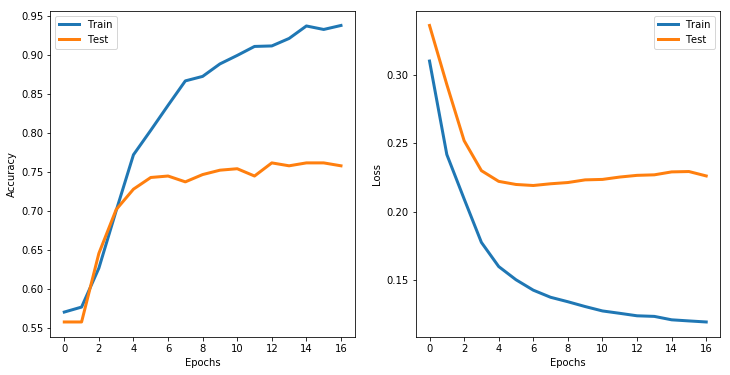

In [26]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(h1.history['acc'],label='Train',linewidth=3)
plt.plot(h1.history['val_acc'],label='Test',linewidth=3)
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.subplot(1,2,2)
plt.plot(h1.history['loss'],label='Train',linewidth=3)
plt.plot(h1.history['val_loss'],label='Test',linewidth=3)
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')

In [28]:
from sklearn.metrics import classification_report
y_pred=model1.predict_classes(Xpadt)
target_names = ['Causa','Tratamiento']
print(classification_report(dftest['Label'].values, y_pred, target_names=target_names))

              precision    recall  f1-score   support

       Causa       0.73      0.90      0.81       297
 Tratamiento       0.82      0.58      0.68       236

   micro avg       0.76      0.76      0.76       533
   macro avg       0.78      0.74      0.74       533
weighted avg       0.77      0.76      0.75       533



In [22]:
opt = Adam(lr=0.0001, decay=1e-5)
es = EarlyStopping(patience=5)
chkpt = ModelCheckpoint(filepath='best_model_todate2', save_best_only=True, save_weights_only=True)
model1 =Sequential()
model1.add(Embedding(2000,128,input_length=voc,mask_zero=True))
model1.add(LSTM(units=196, input_shape=out.shape,recurrent_dropout=0.2))
model1.add(Dropout(0.2))
model1.add(Dense(units=1,activation='sigmoid',activity_regularizer=regularizers.l2(0.01)))
model1.compile(optimizer=opt,loss='binary_crossentropy',metrics=['acc'])
h1=model1.fit(Xpad,df['Label'].values,epochs=25, batch_size=32,validation_data=(Xpadt,dftest['Label'].values),class_weight={0:0.75, 1:1.0},callbacks=[es, chkpt])

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Train on 1558 samples, validate on 533 samples
Epoch 1/25
1558/1558 [==============================] - 7s 4ms/step - loss: 0.6712 - acc: 0.5610 - val_loss: 0.7614 - val_acc: 0.5572
Epoch 2/25
1558/1558 [==============================] - 6s 4ms/step - loss: 0.6552 - acc: 0.5700 - val_loss: 0.7179 - val_acc: 0.5591
Epoch 3/25
1558/1558 [==============================] - 6s 4ms/step - loss: 0.5923 - acc: 0.6784 - val_loss: 0.6461 - val_acc: 0.7861
Epoch 4/25
1558/1558 [==============================] - 6s 4ms/step - loss: 0.4958 - acc: 0.8479 - val_loss: 0.6009 - val_acc: 0.7992
Epoch 5/25
1558/1558 [==============================] - 6s 4ms/step - loss: 0.4315 - acc: 0.8864 - val_loss: 0.5708 - val_acc: 0.8011
Epoch 6/25
1558/1558 [==============================] - 6s 4ms/step - loss: 0.3848 - acc: 0.8967 - val_loss: 0.5743 - va

Text(0,0.5,'Loss')

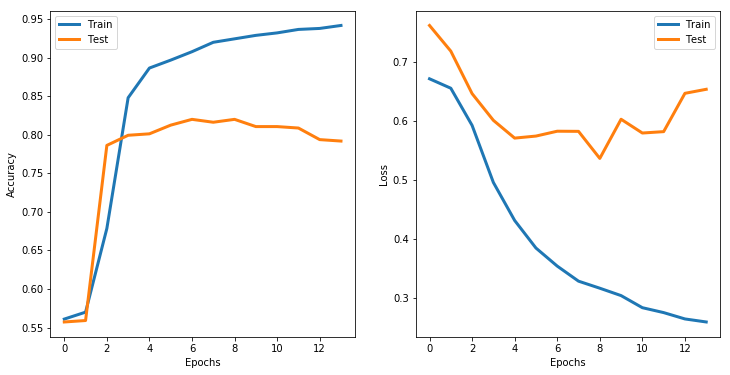

In [23]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(h1.history['acc'],label='Train',linewidth=3)
plt.plot(h1.history['val_acc'],label='Test',linewidth=3)
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.subplot(1,2,2)
plt.plot(h1.history['loss'],label='Train',linewidth=3)
plt.plot(h1.history['val_loss'],label='Test',linewidth=3)
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')

In [29]:
y_pred=model1.predict_classes(Xpadt)
target_names = ['Causa','Tratamiento']
print(classification_report(dftest['Label'].values, y_pred, target_names=target_names))

              precision    recall  f1-score   support

       Causa       0.73      0.90      0.81       297
 Tratamiento       0.82      0.58      0.68       236

   micro avg       0.76      0.76      0.76       533
   macro avg       0.78      0.74      0.74       533
weighted avg       0.77      0.76      0.75       533



# Utilizaremos GLOVE para conservar la estructura correlacion semantica de las frases y comparar resultados.

In [30]:
pip install glove_python

     |████████████████████████████████| 266kB 4.9MB/s 
  Stored in directory: /root/.cache/pip/wheels/88/4b/6d/10c0d2ad32c9d9d68beec9694a6f0b6e83ab1662a90a089a4b
Successfully built glove-python


In [31]:
from glove import Corpus, Glove
corpus = Corpus()
corpus.fit(aW, window=10)
glove = Glove(no_components=128, learning_rate=0.05)
glove.fit(corpus.matrix, epochs=50, no_threads=4, verbose=True)
glove.add_dictionary(corpus.dictionary)

Performing 50 training epochs with 4 threads
Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
Epoch 16
Epoch 17
Epoch 18
Epoch 19
Epoch 20
Epoch 21
Epoch 22
Epoch 23
Epoch 24
Epoch 25
Epoch 26
Epoch 27
Epoch 28
Epoch 29
Epoch 30
Epoch 31
Epoch 32
Epoch 33
Epoch 34
Epoch 35
Epoch 36
Epoch 37
Epoch 38
Epoch 39
Epoch 40
Epoch 41
Epoch 42
Epoch 43
Epoch 44
Epoch 45
Epoch 46
Epoch 47
Epoch 48
Epoch 49


#### Analicemos los terminos de interes mediante las relaciones obtenidas en Glove

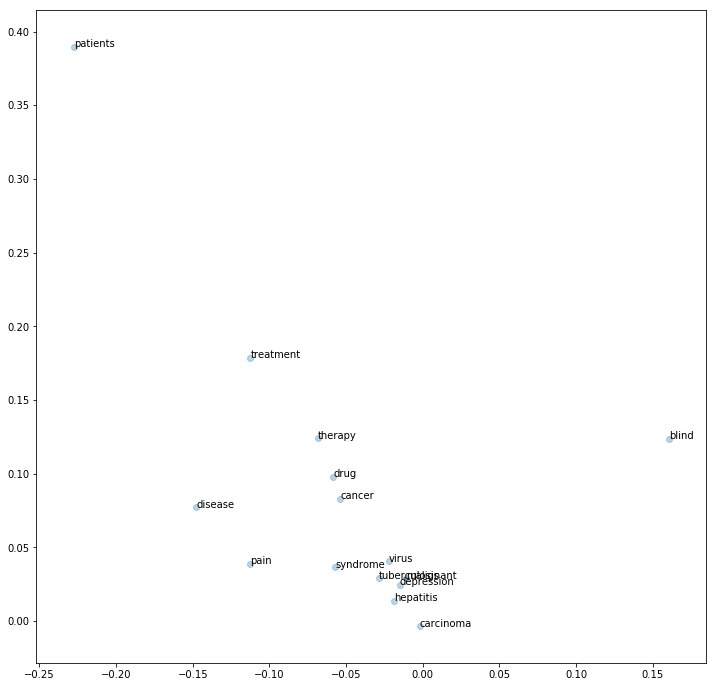

In [32]:
TerminosDeInteres = ['patients','virus','therapy','treatment','malignant','drug','disease','pain','tuberculosis','syndrome','carcinoma','cancer','hepatitis','blind','depression']
Nterm = len(TerminosDeInteres)
indice = np.zeros(Nterm, dtype=int)

for i in range(Nterm):
    indice[i] = corpus.dictionary.get(TerminosDeInteres[i])
wordembedding = glove.word_vectors[indice,:]

fig, ax = plt.subplots(figsize=(12,12))
ax.scatter(wordembedding[:,0], wordembedding[:,1], alpha=0.3)

for i, txt in enumerate(TerminosDeInteres):
    ax.annotate(txt, (wordembedding[i,0], wordembedding[i,1]))

* Se agrupan las palabras correspondientes a enfermedades y quedan mas lejanas otras con menos relacion directa.
* Busquemos palabras similares a otras para observar la estructura de correlacion que crea Glove

In [33]:
glove.most_similar('treatment')

[('infections', 0.9928024030118786),
 ('caused', 0.991677725754227),
 ('alternative', 0.9894810575402998),
 ('nocardia', 0.9854341840825548)]

In [34]:
glove.most_similar('disease')

[('crohn', 0.9910160378173141),
 ('huntington', 0.9901044745450923),
 ('graves', 0.9842969097085409),
 ('parkinson', 0.982200398138444)]

In [35]:
glove.most_similar('cancer')

[('group', 0.9903850039391665),
 ('female', 0.9890881511548778),
 ('receiving', 0.9866996180055),
 ('treated', 0.9854328804467579)]

In [36]:
glove.inverse_dictionary

{0: 'lacunes',
 1: 'consist',
 2: 'small',
 3: 'vascular',
 4: 'lesions',
 5: 'volume',
 6: 'mm',
 7: 'these',
 8: 'lacunar',
 9: 'infarctions',
 10: 'determined',
 11: 'ischemia',
 12: 'caused',
 13: 'obstructive',
 14: 'diseases',
 15: 'terminal',
 16: 'vessels',
 17: 'deep',
 18: 'areas',
 19: 'brain',
 20: 'ticks',
 21: 'collected',
 22: 'winter',
 23: 'tick',
 24: 'dermacentor',
 25: 'albipictus',
 26: 'deer',
 27: 'ixodes',
 28: 'dammini',
 29: 'primary',
 30: 'vector',
 31: 'causative',
 32: 'agent',
 33: 'lyme',
 34: 'disease',
 35: 'borrelia',
 36: 'burgdorferi',
 37: 'diabetic',
 38: 'neuropathy',
 39: 'frequent',
 40: 'complication',
 41: 'diabetes',
 42: 'leading',
 43: 'cause',
 44: 'polyneuropathy',
 45: 'western',
 46: 'world',
 47: 'latent',
 48: 'viral',
 49: 'infections',
 50: 'increased',
 51: 'risk',
 52: 'reactivation',
 53: 'including',
 54: 'bk',
 55: 'virus',
 56: 'associated',
 57: 'nephropathy',
 58: 'bkvn',
 59: 'granuloma',
 60: 'inguinale',
 61: 'donovanosi

In [37]:
tokenizer.index_word

{1: 'patients',
 2: 'treatment',
 3: 'may',
 4: 'disease',
 5: 'pain',
 6: 'caused',
 7: 'syndrome',
 8: 'in',
 9: 'therapy',
 10: 'et',
 11: 'al',
 12: 'trial',
 13: 'drug',
 14: 'infections',
 15: 'used',
 16: 'associated',
 17: 'hypertension',
 18: 'infection',
 19: 'symptoms',
 20: 'acute',
 21: 'type',
 22: 'clinical',
 23: 'study',
 24: 'mg',
 25: 'diabetes',
 26: 'severe',
 27: 'chronic',
 28: 'fever',
 29: 'virus',
 30: 'use',
 31: 'cause',
 32: 'risk',
 33: 'dose',
 34: 'insulin',
 35: 'patient',
 36: 'effective',
 37: 'oral',
 38: 'diarrhea',
 39: 'increased',
 40: 'and',
 41: 'high',
 42: 'agents',
 43: 'cases',
 44: 'controlled',
 45: 'effects',
 46: 'also',
 47: 'causes',
 48: 'diagnosis',
 49: 'efficacy',
 50: 'children',
 51: 'cell',
 52: 'low',
 53: 'combination',
 54: 'bone',
 55: 'randomized',
 56: 'disorder',
 57: 'arthritis',
 58: 'carcinoma',
 59: 'related',
 60: 'present',
 61: 'allergic',
 62: 'often',
 63: 'seizures',
 64: 'renal',
 65: 'skin',
 66: 'treated',
 

## Transferimos los pesos del GLOVE para ellos encontraremos las posiciones correspondientes a las palabras del embedding .

In [0]:
def searchword(search):
    for x, y in glove.inverse_dictionary.items():
        if y == search:
            return(x)

In [39]:
wg=glove.word_vectors
glove.word_vectors.shape

(7194, 128)

In [40]:
we=model1.get_weights()
model1.get_weights()[0].shape

(2000, 128)

In [0]:
we1=we
for i in range(2000):
    we1[0][i]=wg[searchword(tokenizer.index_word[i+1])]

In [0]:
opt = Adam(lr=0.0001, decay=1e-5)
es = EarlyStopping(patience=5)
chkpt = ModelCheckpoint(filepath='best_model_todate3', save_best_only=True, save_weights_only=True)
model1 =Sequential()
model1.add(Embedding(2000,128,input_length=voc,mask_zero=True))
model1.add(LSTM(units=196, input_shape=out.shape,recurrent_dropout=0.2))
model1.add(Dropout(0.2))
model1.add(Dense(units=1,activation='sigmoid',activity_regularizer=regularizers.l2(0.01)))
model1.compile(optimizer=opt,loss='binary_crossentropy',metrics=['acc'])

In [50]:
model1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 25, 128)           256000    
_________________________________________________________________
lstm_4 (LSTM)                (None, 196)               254800    
_________________________________________________________________
dropout_4 (Dropout)          (None, 196)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 197       
Total params: 510,997
Trainable params: 510,997
Non-trainable params: 0
_________________________________________________________________


* Transferencia de pesos!

In [0]:
w=model1.get_weights()
w[0]=we1[0]
model1.set_weights(w)

In [52]:
h1=model1.fit(Xpad,df['Label'].values,epochs=25, batch_size=32,validation_data=(Xpadt,dftest['Label'].values),class_weight={0:0.8, 1:1.0},callbacks=[es, chkpt])

Train on 1558 samples, validate on 533 samples
Epoch 1/25
1558/1558 [==============================] - 7s 5ms/step - loss: 0.6884 - acc: 0.5899 - val_loss: 0.7537 - val_acc: 0.5666
Epoch 2/25
1558/1558 [==============================] - 6s 4ms/step - loss: 0.6675 - acc: 0.5879 - val_loss: 0.7066 - val_acc: 0.6060
Epoch 3/25
1558/1558 [==============================] - 6s 4ms/step - loss: 0.6170 - acc: 0.6470 - val_loss: 0.6711 - val_acc: 0.6923
Epoch 4/25
1558/1558 [==============================] - 6s 4ms/step - loss: 0.5480 - acc: 0.7670 - val_loss: 0.6161 - val_acc: 0.7655
Epoch 5/25
1558/1558 [==============================] - 6s 4ms/step - loss: 0.4800 - acc: 0.8408 - val_loss: 0.5881 - val_acc: 0.7786
Epoch 6/25
1558/1558 [==============================] - 6s 4ms/step - loss: 0.4258 - acc: 0.8742 - val_loss: 0.5664 - val_acc: 0.8030
Epoch 7/25
1558/1558 [==============================] - 6s 4ms/step - loss: 0.3929 - acc: 0.8902 - val_loss: 0.5488 - val_acc: 0.8124
Epoch 8/25
1558

Text(0,0.5,'Loss')

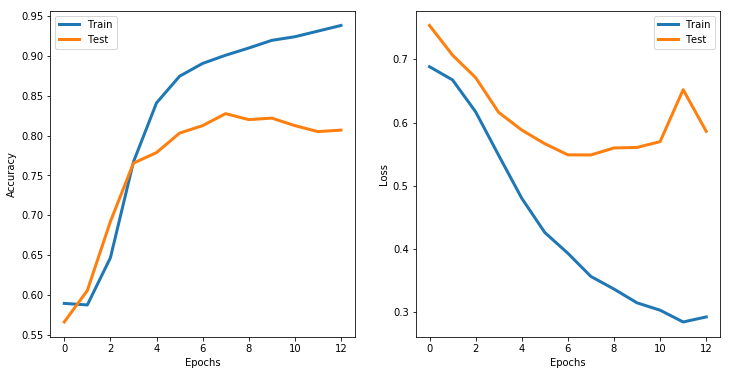

In [53]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(h1.history['acc'],label='Train',linewidth=3)
plt.plot(h1.history['val_acc'],label='Test',linewidth=3)
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.subplot(1,2,2)
plt.plot(h1.history['loss'],label='Train',linewidth=3)
plt.plot(h1.history['val_loss'],label='Test',linewidth=3)
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')

In [54]:
y_pred=model1.predict_classes(Xpadt)
target_names = ['Causa','Tratamiento']
print(classification_report(dftest['Label'].values, y_pred, target_names=target_names))

              precision    recall  f1-score   support

       Causa       0.84      0.80      0.82       297
 Tratamiento       0.76      0.81      0.79       236

   micro avg       0.81      0.81      0.81       533
   macro avg       0.80      0.81      0.81       533
weighted avg       0.81      0.81      0.81       533



## La implementacion de GLOVE  y la transferencia de los pesos mejoro los resultados obtenidos   mejorando la sensibilidad del clasificador, ademas permite hacer un mayor analisis del problema y de la informacion disponible.
 ### Nuestro clasificador final tiene precision de 80%